# <center>Visualization & Style Transfer<center/>

<center>Shan-Hung Wu & DataLab<center/>
<center>Fall 2023<center/>

This tutorial is going to show how to load and use a pretrained model from tensorflow library and discusses some techniques to visualize what the networks represent in the selected layers. In addition, we will introduce an interesting work called neural style transfer, using deep learning to compose one image in the style of another image.

## Import and configure modules

In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import os


''' 
runtime configuration parameters 
設定了兩個參數:
1. figure.figsize : 設定繪圖的預設圖片尺寸為 (12, 12) 英吋
2. axes.grid : 將繪圖中的網格（grid）關閉，即設為 False
'''
mpl.rcParams['figure.figsize'] = (12,12) 
mpl.rcParams['axes.grid'] = False

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# <center>Visualize Convolutional Neural Networks<center/>

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # 將圖片的數據類型轉換為 tf.float32。這是為了將像素值縮放到範圍 [0, 1]，以便進行後續的處理。
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  # 將 shape 的 tensor 轉換為 float32
    long_dim = max(shape) 
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32) # 滿足 max_dim 的 shape

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :] # 增加一個 batch 的維度
    
    return img

Create a simple function to display an image:

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 341, 512, 3)


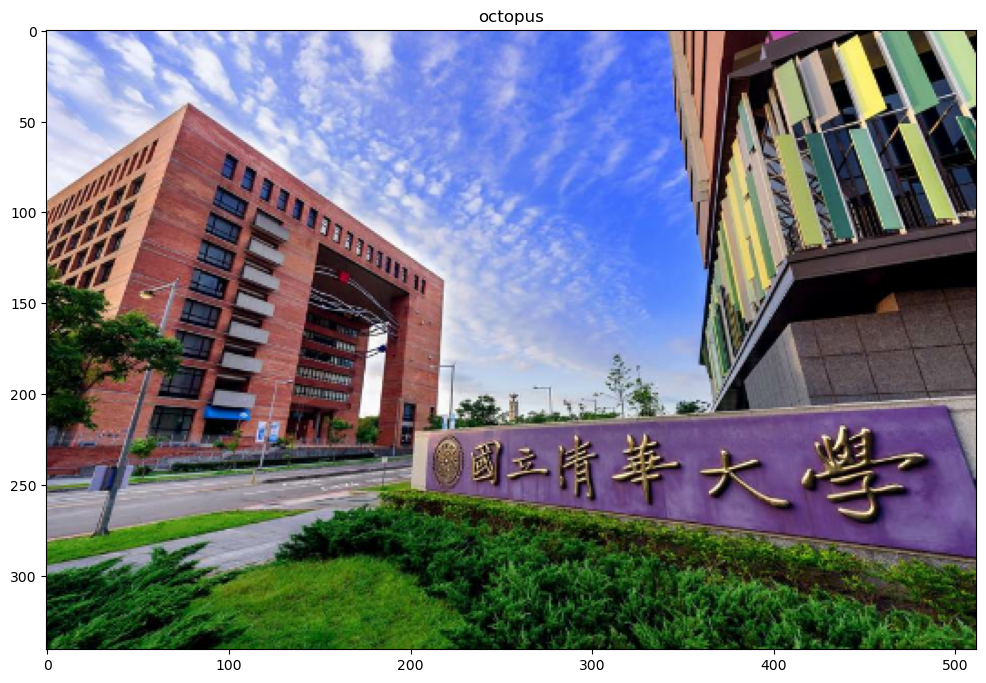

In [5]:
content_path = './content_nthu.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'octopus')

## Load a pretrained network (VGG19)

We are going to visualize one of most remarkable neural networks, VGG19, which is introduced from this [paper](https://arxiv.org/abs/1409.1556), pretrained on ImageNet. VGG19 is known for its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. The "19" in its name stands for the number of layers in the network. ImageNet is a large dataset used in ImageNet Large Scale Visual Recognition Challenge(ILSVRC). The training dataset contains around 1.2 million images composed of 1000 different types of objects. The pretrained network learned how to create useful representations of the data to differentiate between different classes.

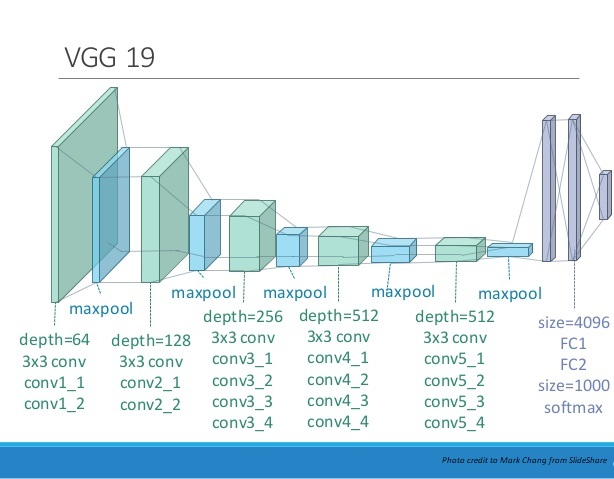

Load a VGG19 and test run it on our image to ensure it's used correctly. The output of VGG19 is the probabilities corresponding to 1000 categories.

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # 以 VGG19 模型的預處理方式來處理一個影像 content_image*255，是因為 VGG19 模型預處理的期望輸入值是在 0 到 255 之間的像素值。
x = tf.image.resize(x, (224, 224)) # VGG19 模型預期的輸入影像大小是 (224, 224, 3)

# load pretrained network(VGG19)
# include_top=True 表示包含模型的頂層（全連接層），而 weights='imagenet' 則表示使用在 ImageNet 數據集上預先訓練好的權重。
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


prediction_probabilities = vgg(x) # 包含類別預測機率的張量
prediction_probabilities.shape

TensorShape([1, 1000])

Obtain the top 5 predicted categories of the input image.

In [7]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('library', 0.5539438),
 ('bookshop', 0.097583316),
 ('bell_cote', 0.06388663),
 ('church', 0.04840348),
 ('cinema', 0.03035519)]

Let's try to first print out the detailed structure of VGG19. vgg.summary() shows the name, output shape and the number of parameters of each layer.

In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Visualize filters

Now we can visualize the weights of the convolution filters to help us understand what neural network have learned. In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

We can access the block of filters and the block of bias values through layer.get_weight(). In VGG19, all convolitional layers use 3x3 filters.

In [9]:
# summarize filter shapes
for layer in vgg.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)


Let's look at every single individual filter in the first convolutional layer. We will see all 64 in the block and plot each of the three channels. It is worth to meantion that in the first convolutional layer, it has total 192 feature maps(64 filters * 3 channels). We can normalize their values to the range 0-1 to make them easy to visualize.

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

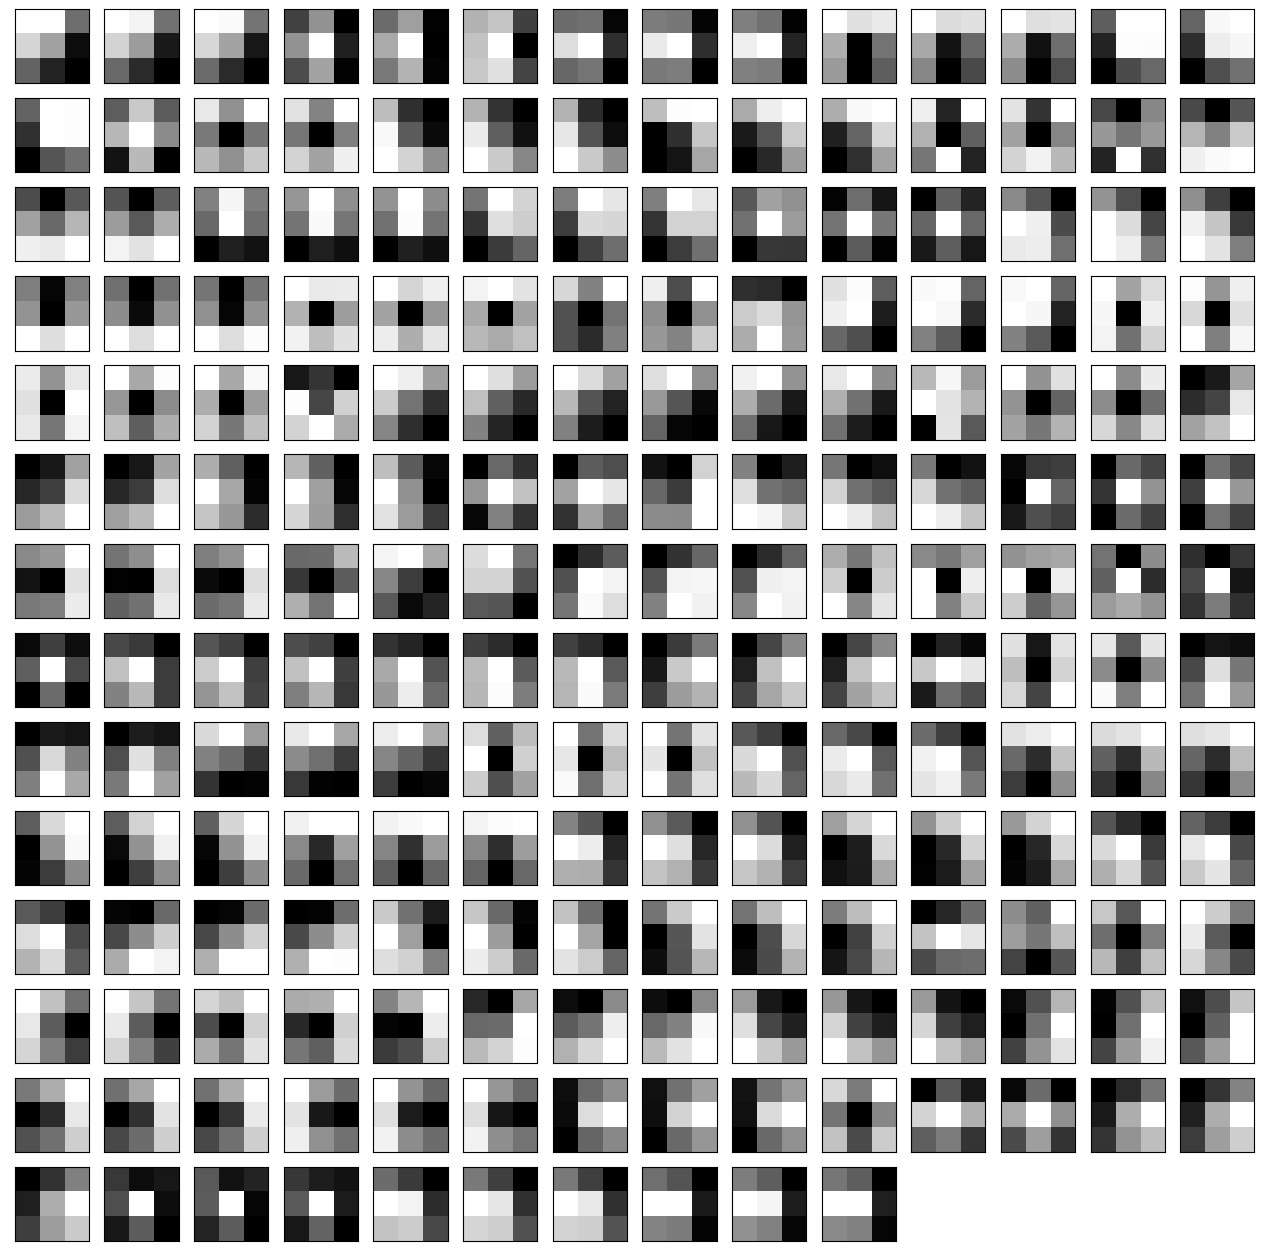

In [10]:
plt.figure(figsize=(16,16))

# retrieve weights from the second hidden layer
filters, biases = vgg.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 64, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

## Visualize feature maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map. The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the input image with different features highlighted. For example, some highlight lines, other focus on the background or the foreground.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 127ms/step


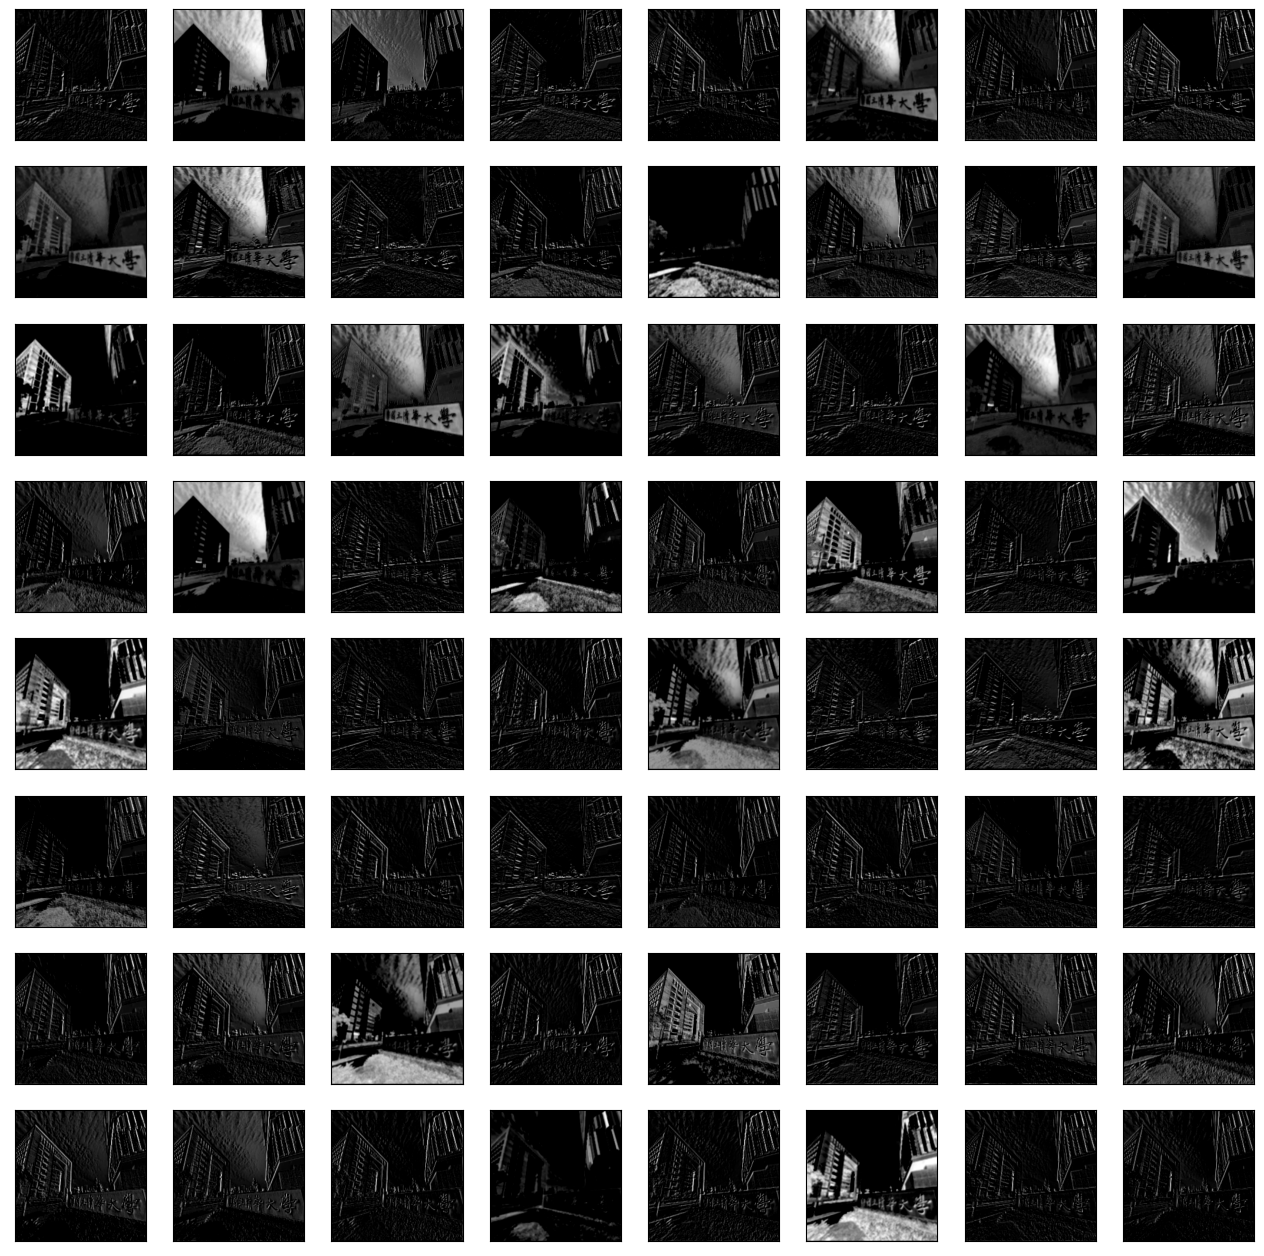

In [11]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[1].output)
model.summary()

# preprocess input
# 在這個上下文中，`content_image*255` 是將 `content_image` 中的每個像素值乘以 255。這通常是因為圖像數據在讀取時被歸一化到了 0 到 1 的範圍
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255) 

content_image = tf.image.resize(content_image, (224, 224))

# get feature map for first hidden layer
feature_maps = model.predict(content_image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

在這個上下文中，`content_image*255` 是將 `content_image` 中的每個像素值乘以 255。這通常是因為圖像數據在讀取時被歸一化到了 0 到 1 的範圍，而原始的像素值範圍是 0 到 255。所以這個操作是將像素值從 0-1 範圍轉換回 0-255 範圍，這是 VGG19 模型預期的輸入範圍。

Let's visualize the feature maps output from each block of the model. You might notice that the number of feature maps (e.g. depth or number of channels) in deeper layers is much more than 64, such as 256 or 512. Nevertheless, we can cap the number of feature maps visualized at 64 for consistency.

We can see that the feature maps closer to the input of the model capture a lot of fine detail in the image and that as we progress deeper into the model, the feature maps show less and less detail.

This pattern was to be expected, as the model abstracts the features from the image into more general concepts that can be used to make a classification. Although it is not clear from the final image that the model saw NTHU campus, we generally lose the ability to interpret these deeper feature maps.

1/1 [==============================] - 9s 9s/step
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")


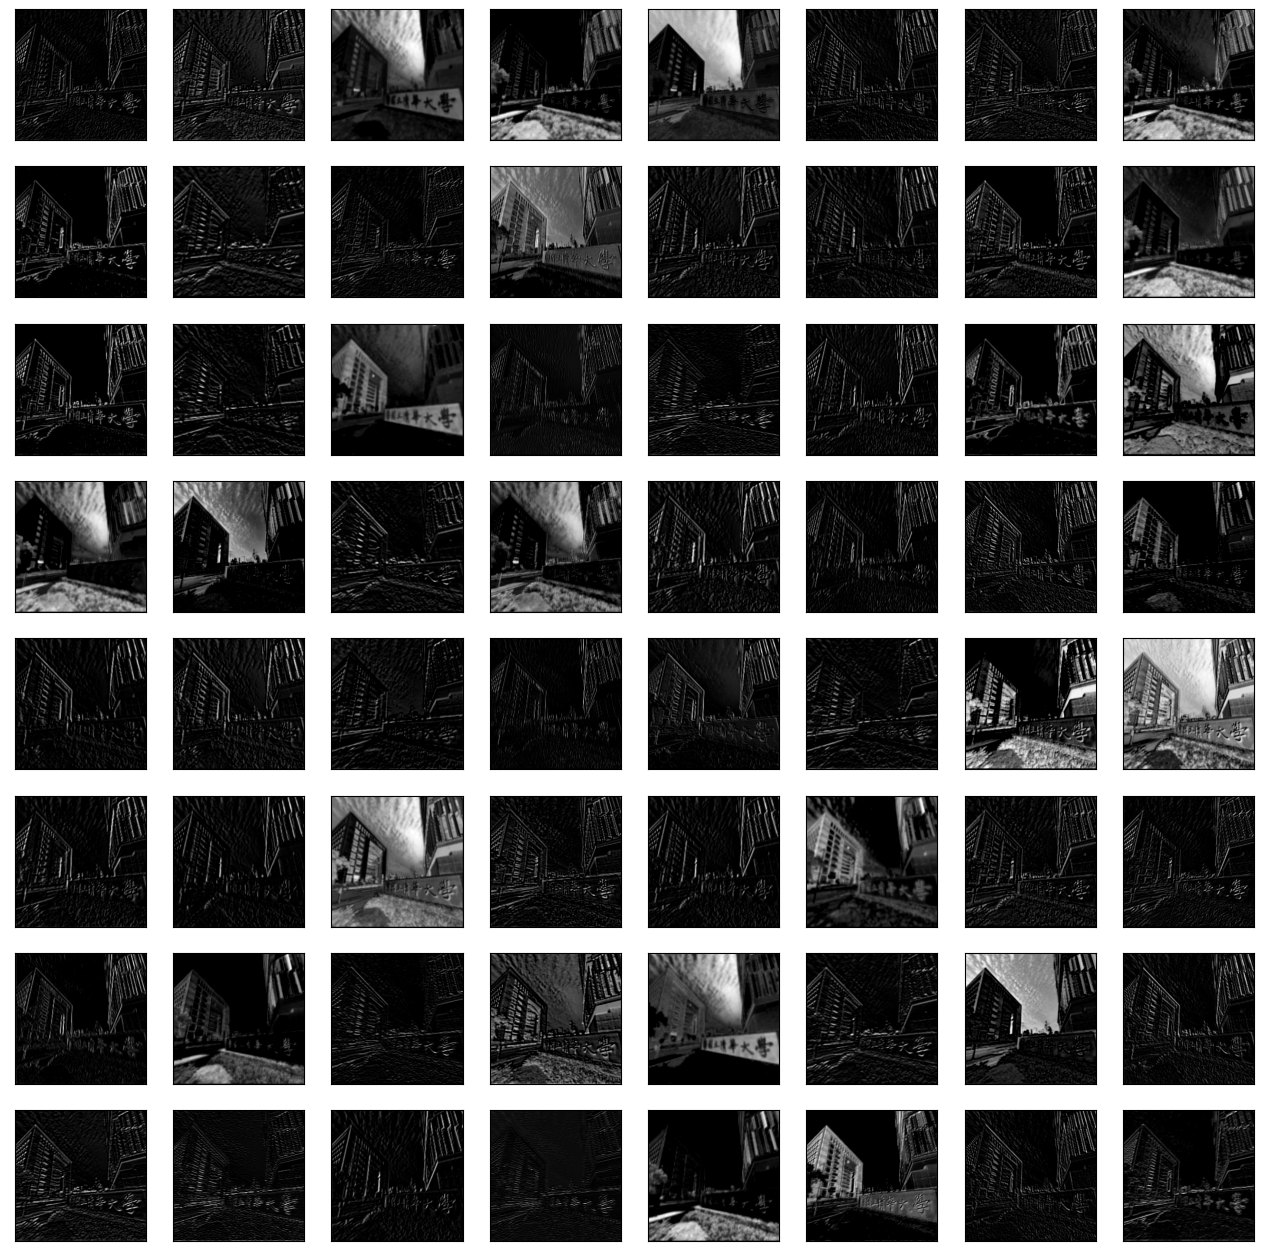

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")


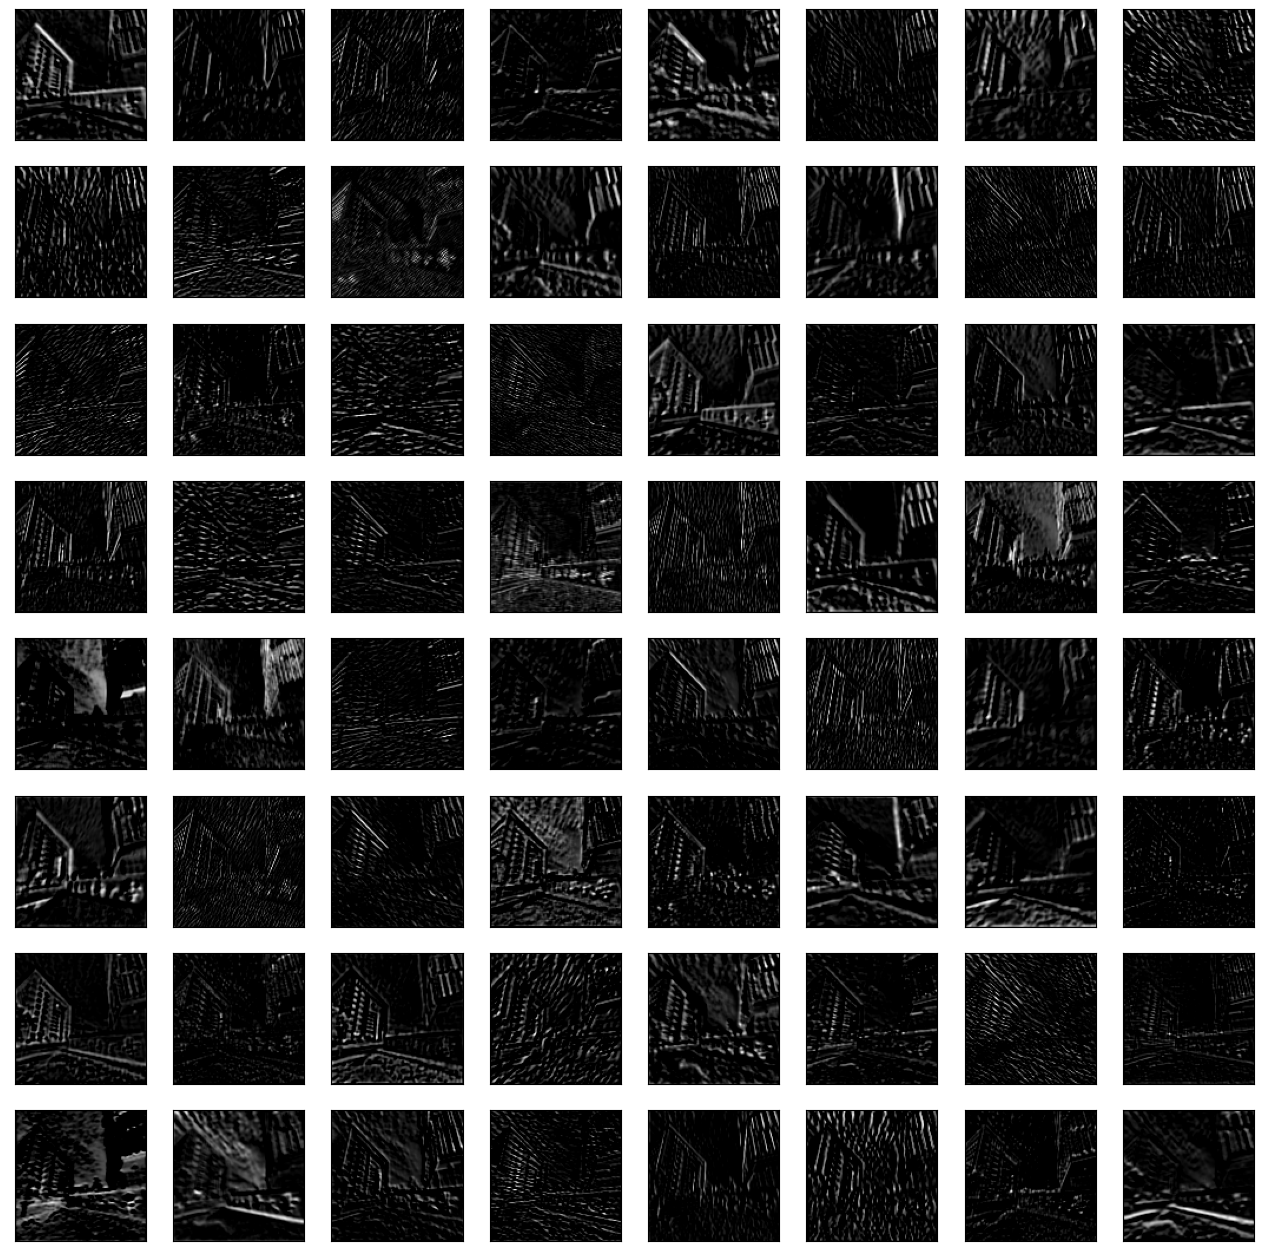

KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='block3_conv4/Relu:0', description="created by layer 'block3_conv4'")


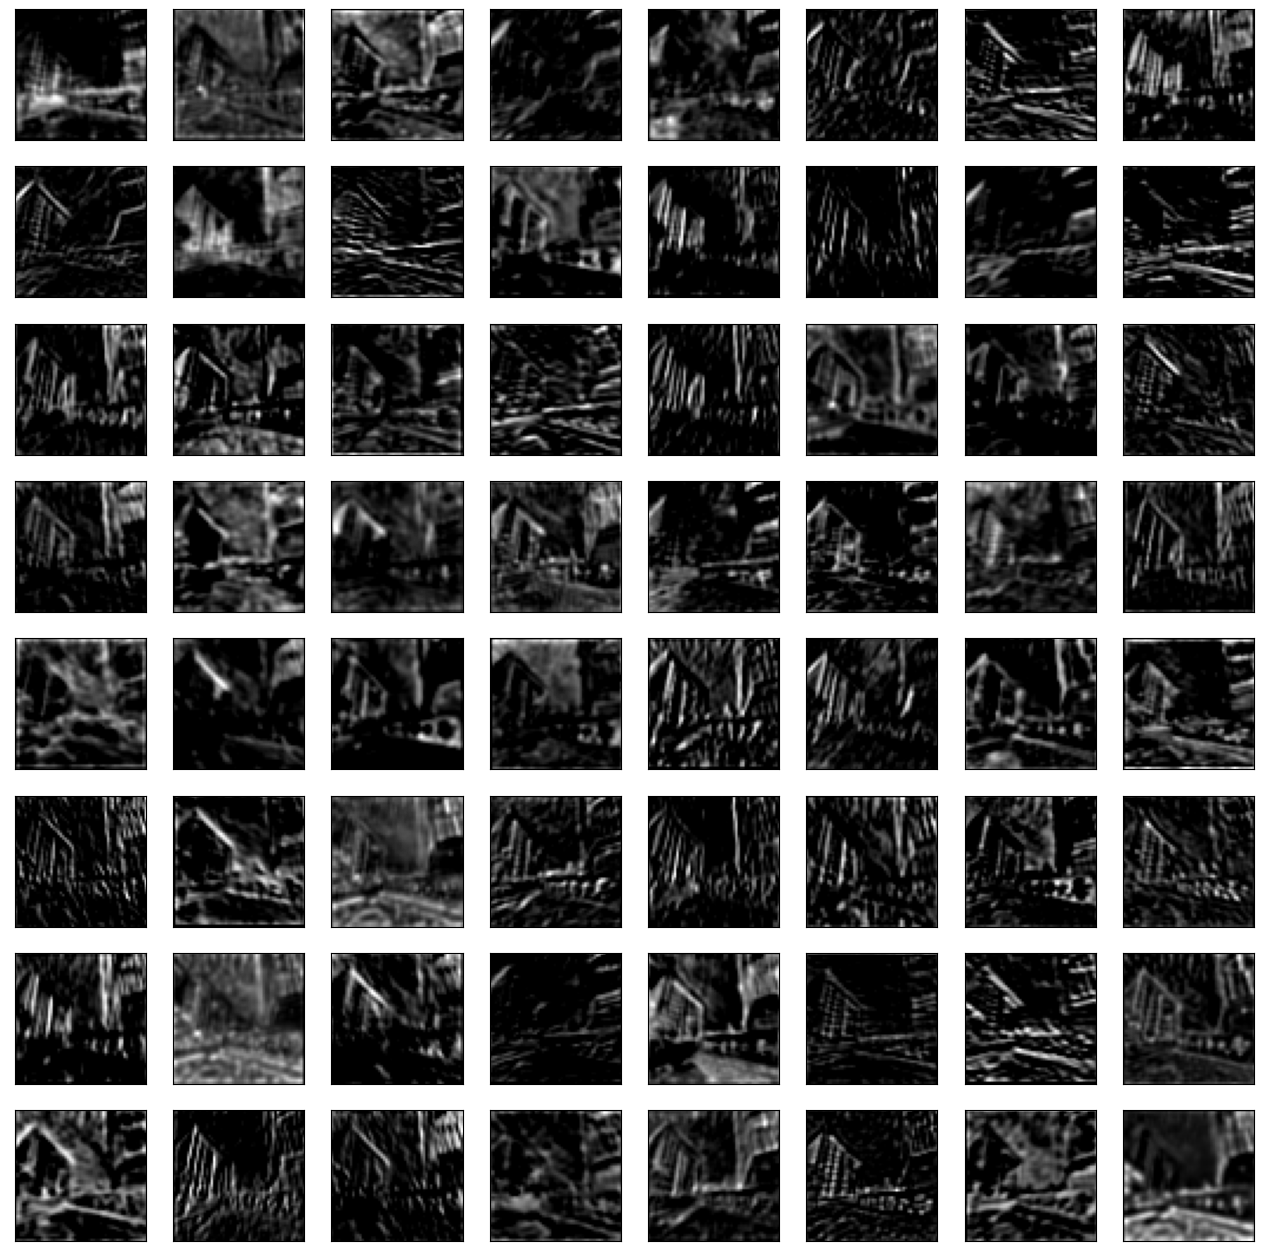

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='block4_conv4/Relu:0', description="created by layer 'block4_conv4'")


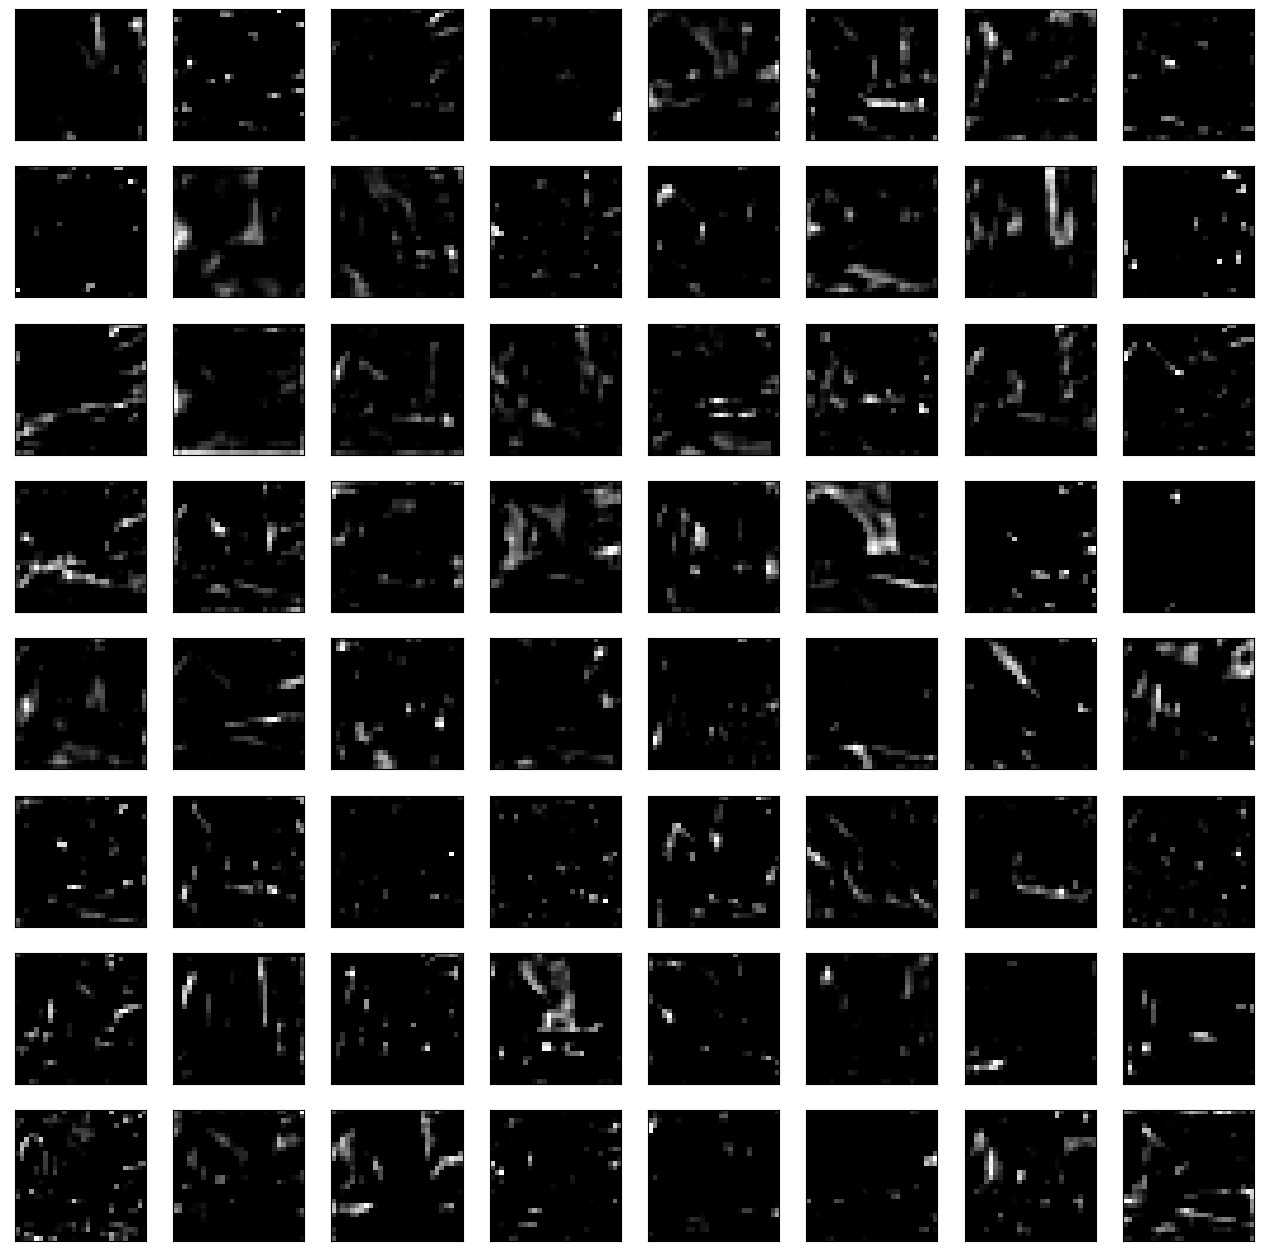

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='block5_conv4/Relu:0', description="created by layer 'block5_conv4'")


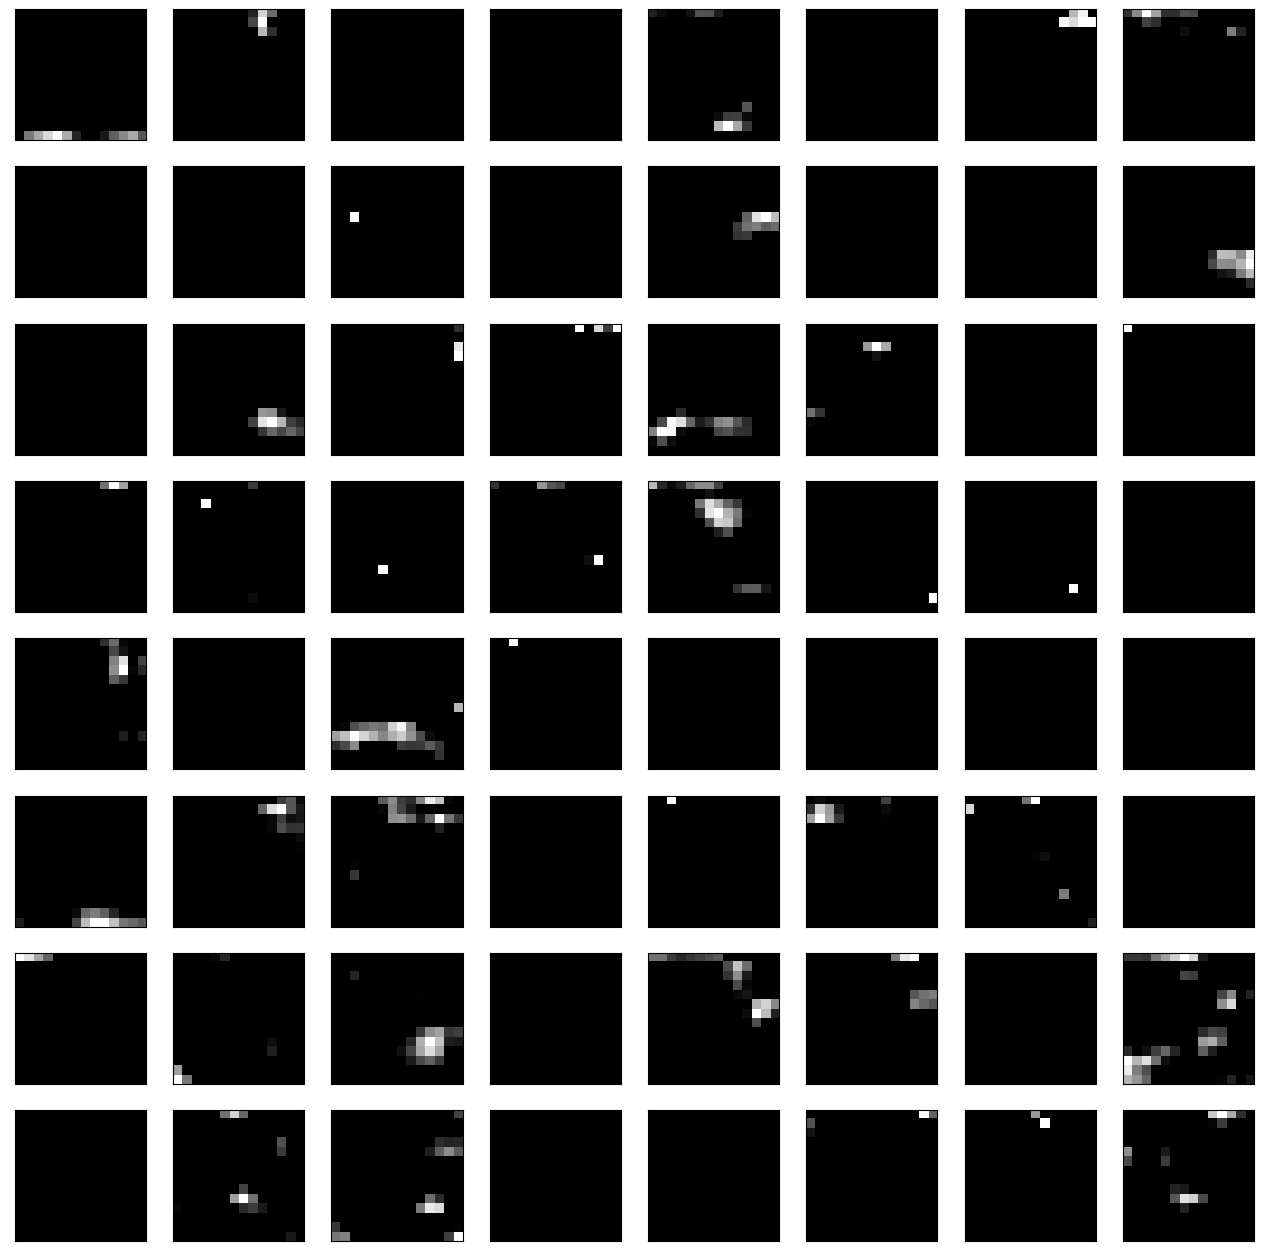

In [12]:
# get feature maps for last convolutional layer in each block
ixs = [2, 5, 10, 15, 20]
outputs = [vgg.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
feature_maps = model.predict(content_image)

# plot the output from each block
square = 8
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
            
    # show the figure
    pyplot.show()

## Visualize gradients

Visualizing convolutional output is a pretty useful technique for visualizing shallow convolution layers, but when we get into the deeper layers, it's hard to understand them just by just looking at the convolution output.

If we want to understand what the deeper layers are really doing, we can try to use backpropagation to show us the gradients of a particular neuron with respect to our input image. We will make a forward pass up to the layer that we are interested in, and then backpropagate to help us understand which pixels contributed the most to the activation of that layer.

We first create an operation which will find the maximum neurons among all activations in the required layer, and then calculate the gradient of that objective with respect to the input image.

In [13]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
class GradientModel(tf.keras.models.Model):
    def __init__(self, layers):
        super(GradientModel, self).__init__()
        self.vgg =  vgg_layers(layers)
        self.num_style_layers = len(layers)
        self.vgg.trainable = False
        
    # return the feature map of required layer
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs

Compute the gradient of maximum neurons among all activations in the required layer with respect to the input image.

In [15]:
@tf.function()
def visualize_gradient(image):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        # grad = d_feature/d_image
        grad = tape.gradient(tf.reduce_max(feature, axis=3), image)
    return grad

In [16]:
content_image = load_img(content_path)

# activation layer
layers = ['block4_conv2']
image = tf.Variable(content_image)
extractor = GradientModel(layers)

grad = visualize_gradient(image)

# look at the range of gradients
print("shape: ", grad.numpy().shape)
print("min: ", grad.numpy().min())
print("max: ", grad.numpy().max())
print("mean: ", grad.numpy().mean())

shape:  (1, 341, 512, 3)
min:  -13889.36
max:  14001.612
mean:  -18.048965


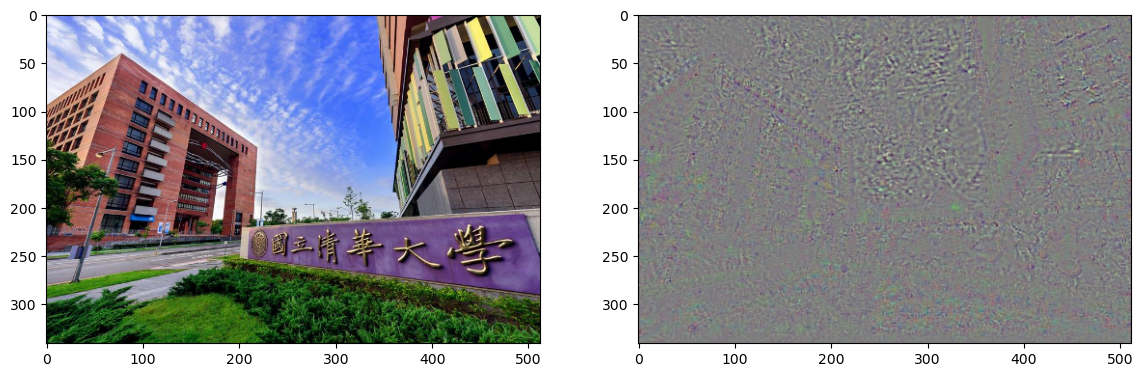

In [27]:
# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])

We can also visualize the gradient of any single feature map.